# Simulated Annealing and GSA for Feature Selection
## Simulated Annealing Algorithm) For Feature Selection on Churn Prediction
___

In [1]:
#import libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from warnings import filterwarnings
filterwarnings('ignore')


import sys
import os

# Get the directory of the current script or notebook
script_dir = os.path.dirname(os.path.abspath("__file__"))

# Construct the full path to the 'src' directory
src_dir = os.path.join(script_dir, '..', 'src')

# Append the 'src' directory to sys.path
sys.path.append(src_dir)

# Construct the full path to the 'data' directory
data_dir = os.path.join(script_dir, '..', 'data')

# Now, you can import the modules and access the data
from main import simulated_annealing
from GSA_implementation import GSA
from benchmarks import F1 
from gsa_sa_iterative import gsa_sa_iterative
from generate_neighbor import generate_neighbor
from utils import fitness_function, train_model


# Load your data (example)
import pandas as pd

#dataset1
#df = pd.read_csv(os.path.join(data_dir, 'churn2.csv'))

#dataset2
#df = pd.read_csv(os.path.join(data_dir, 'ChurnNormalize.csv'))

#dataset3
train = pd.read_csv(os.path.join(data_dir, 'cell2celltrain.csv'))
test = pd.read_csv(os.path.join(data_dir, 'cell2cellholdout.csv'))




In [2]:


test.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 20000 non-null  int64  
 1   Churn                      0 non-null      float64
 2   MonthlyRevenue             19940 non-null  float64
 3   MonthlyMinutes             19940 non-null  float64
 4   TotalRecurringCharge       19940 non-null  float64
 5   DirectorAssistedCalls      19940 non-null  float64
 6   OverageMinutes             19940 non-null  float64
 7   RoamingCalls               19940 non-null  float64
 8   PercChangeMinutes          19865 non-null  float64
 9   PercChangeRevenues         19865 non-null  float64
 10  DroppedCalls               20000 non-null  float64
 11  BlockedCalls               20000 non-null  float64
 12  UnansweredCalls            20000 non-null  float64
 13  CustomerCareCalls          20000 non-null  flo

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 51047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             50891 non-null  float64
 3   MonthlyMinutes             50891 non-null  float64
 4   TotalRecurringCharge       50891 non-null  float64
 5   DirectorAssistedCalls      50891 non-null  float64
 6   OverageMinutes             50891 non-null  float64
 7   RoamingCalls               50891 non-null  float64
 8   PercChangeMinutes          50680 non-null  float64
 9   PercChangeRevenues         50680 non-null  float64
 10  DroppedCalls               51047 non-null  float64
 11  BlockedCalls               51047 non-null  float64
 12  UnansweredCalls            51047 non-null  float64
 13  CustomerCareCalls          51047 non-null  flo

In [4]:
#Churn : Yes:1 , No:0
Churn = {'Yes': 1,'No': 0} 
  
# traversing through dataframe 
# values where key matches 
train.Churn = [Churn[item] for item in train.Churn] 
print(train)

       CustomerID  Churn  MonthlyRevenue  MonthlyMinutes  \
0         3000002      1           24.00           219.0   
1         3000010      1           16.99            10.0   
2         3000014      0           38.00             8.0   
3         3000022      0           82.28          1312.0   
4         3000026      1           17.14             0.0   
...           ...    ...             ...             ...   
51042     3399958      1             NaN             NaN   
51043     3399974      0           95.17          1745.0   
51044     3399978      1             NaN             NaN   
51045     3399990      0             NaN             NaN   
51046     3399994      0             NaN             NaN   

       TotalRecurringCharge  DirectorAssistedCalls  OverageMinutes  \
0                      22.0                   0.25             0.0   
1                      17.0                   0.00             0.0   
2                      38.0                   0.00             0.0   

In [17]:
train = train.drop(columns=['CustomerID'])

In [18]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Load your datasets
#train = pd.read_csv('path_to_train_dataset.csv')
#test = pd.read_csv('path_to_test_dataset.csv')

# Step 1: Handle Missing Values
# Define a function for consistent preprocessing
def preprocess_missing_values(df):
    for col in df.columns:
        if df[col].dtype == 'object':  # Categorical column
            df[col].fillna(df[col].mode()[0], inplace=True)  # Replace with mode
        else:  # Numerical column
            df[col].fillna(df[col].median(), inplace=True)  # Replace with median
    return df

# Apply to both datasets
train = preprocess_missing_values(train)
test = preprocess_missing_values(test)

# Step 2: Encode Categorical Features
# Define a function for encoding
def encode_categorical_features(df):
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':  # Only encode categorical columns
            df[col] = le.fit_transform(df[col].astype(str))
    return df

# Apply encoding to both datasets
train = encode_categorical_features(train)
test = encode_categorical_features(test)

# Step 3: Save the Preprocessed Data
#train.to_csv('train_preprocessed.csv', index=False)
#test.to_csv('test_preprocessed.csv', index=False)

#print("Preprocessing complete! Data saved as 'train_preprocessed.csv' and 'test_preprocessed.csv'.")



# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Select all numerical columns except the target column
numerical_columns = train.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns.remove('Churn')  # Exclude the target column

# Apply MinMaxScaler to the training and testing datasets
train[numerical_columns] = scaler.fit_transform(train[numerical_columns])
test[numerical_columns] = scaler.transform(test[numerical_columns])

# Save the scaled datasets
train.to_csv('train_scaled.csv', index=False)
test.to_csv('test_scaled.csv', index=False)

print("Scaling complete! Scaled datasets saved as 'train_scaled.csv' and 'test_scaled.csv'.")


Scaling complete! Scaled datasets saved as 'train_scaled.csv' and 'test_scaled.csv'.


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the preprocessed datasets
#train_data = pd.read_csv('train_scaled.csv')
#test_data = pd.read_csv('test_scaled.csv')

train_data = pd.read_csv(os.path.join(data_dir, 'train_scaled.csv'))
#test_data = pd.read_csv(os.path.join(data_dir, 'test_scaled.csv'))


# Define the features (X) and target (Y)
X = train_data.drop(columns=['Churn'])  # Replace 'Churn' with the name of your target column
Y = train_data['Churn']

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)


#X_test = test_data.drop(columns=['Churn'])  # Replace 'Churn' with the name of your target column
#Y_test = test_data['Churn']




# Initialize k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can change 'n_neighbors' as needed

# # Train the k-NN model
knn.fit(X_train, Y_train)


# Step 3: Evaluate the model on the validation set
Y_val_pred = knn.predict(X_val)

accuracy = accuracy_score(Y_val, Y_val_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(Y_val, Y_val_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(Y_val, Y_val_pred))


Validation Accuracy: 0.66

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78     10905
           1       0.33      0.17      0.22      4410

    accuracy                           0.66     15315
   macro avg       0.52      0.51      0.50     15315
weighted avg       0.61      0.66      0.62     15315


Confusion Matrix:
[[9416 1489]
 [3679  731]]



Scaled Data Metrics:
Accuracy: 0.66
Precision: 0.33
Recall: 0.17
F1 Score: 0.22
AUC: 0.52


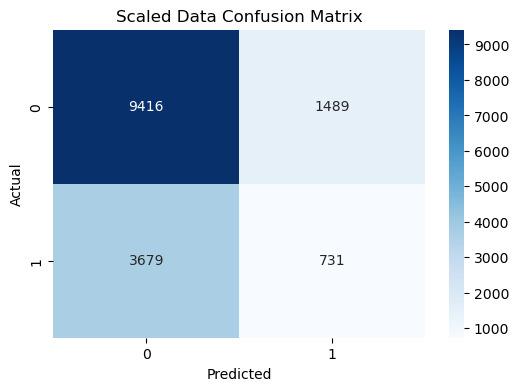


Unscaled Data Metrics:
Accuracy: 0.66
Precision: 0.31
Recall: 0.16
F1 Score: 0.21
AUC: 0.53


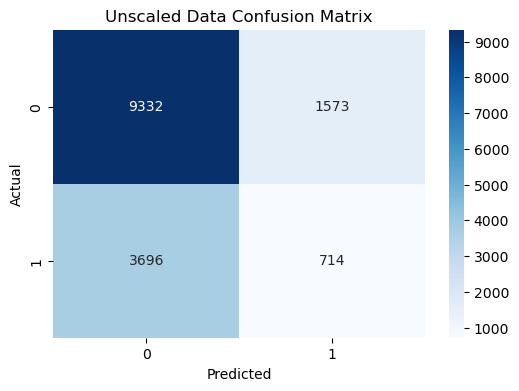

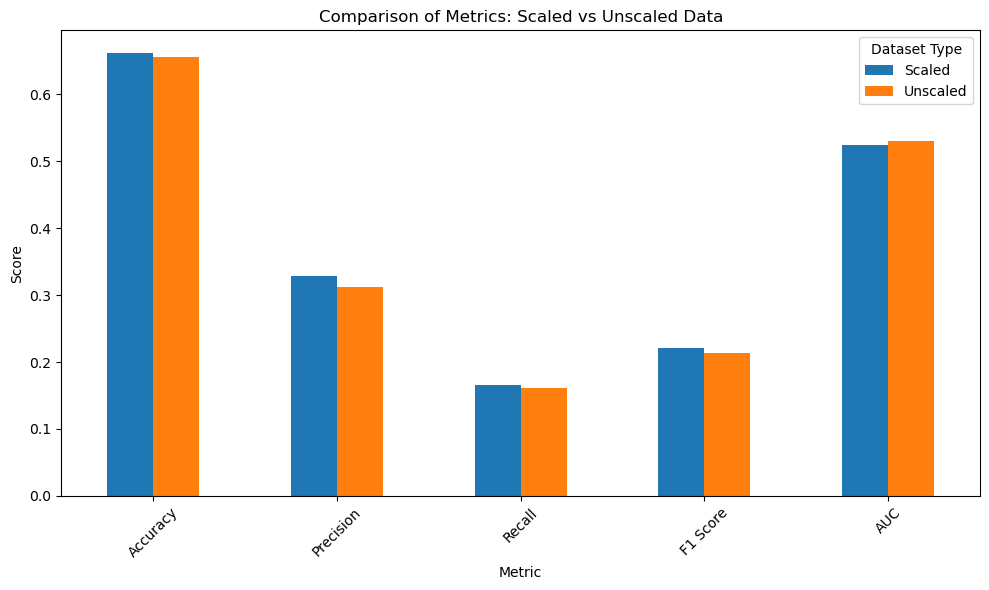

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your datasets
train_data_scaled = pd.read_csv(os.path.join(data_dir, 'train_scaled.csv'))  # Scaled training dataset
train_data_unscaled = pd.read_csv(os.path.join(data_dir, 'train_preprocessed.csv')) # Unscaled training dataset (replace with your file)


# Function to train and evaluate the model
def evaluate_knn(data, title):
    # Step 1: Split dataset
    X = data.drop(columns=['Churn'])  # Features
    Y = data['Churn']  # Target
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

    # Step 2: Train k-NN model
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, Y_train)

    # Step 3: Make predictions
    Y_val_pred = knn.predict(X_val)
    Y_val_prob = knn.predict_proba(X_val)[:, 1]  # For AUC

    # Step 4: Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(Y_val, Y_val_pred),
        'Precision': precision_score(Y_val, Y_val_pred),
        'Recall': recall_score(Y_val, Y_val_pred),
        'F1 Score': f1_score(Y_val, Y_val_pred),
        'AUC': roc_auc_score(Y_val, Y_val_prob),
    }

    # Print metrics
    print(f"\n{title} Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

    # Step 5: Confusion Matrix
    cm = confusion_matrix(Y_val, Y_val_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return metrics

# Evaluate scaled dataset
metrics_scaled = evaluate_knn(train_data_scaled, 'Scaled Data')

# Evaluate unscaled dataset
metrics_unscaled = evaluate_knn(train_data_unscaled, 'Unscaled Data')

# Step 6: Compare and Visualize Metrics
metrics_df = pd.DataFrame({'Scaled': metrics_scaled, 'Unscaled': metrics_unscaled})
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Metrics: Scaled vs Unscaled Data')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(title='Dataset Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Scaled Data Cross-Validation Metrics:
Accuracy: 0.66
Precision: 0.31
Recall: 0.16
F1 Score: 0.22
AUC: 0.52

Unscaled Data Cross-Validation Metrics:
Accuracy: 0.45
Precision: 0.20
Recall: 0.47
F1 Score: 0.28
AUC: 0.46


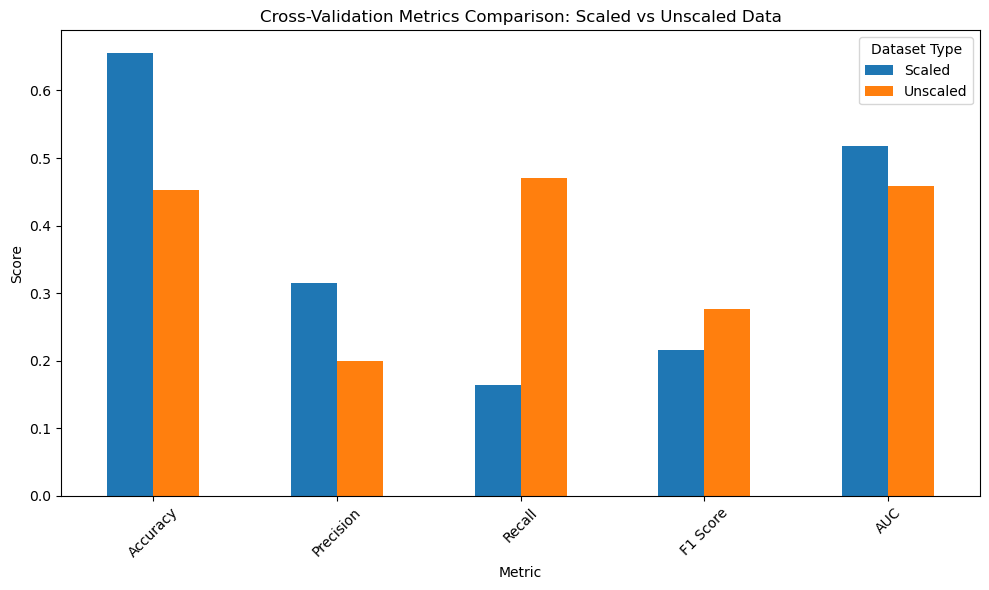

In [16]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Function to perform 5-fold cross-validation and calculate metrics
def cross_validate_knn(data, title):
    # Separate features and target
    X = data.drop(columns=['Churn'])  # Features
    Y = data['Churn']  # Target

    # Initialize k-NN model
    knn = KNeighborsClassifier(n_neighbors=5)

    # Perform 5-fold cross-validation for accuracy, precision, recall, F1-score, and AUC
    accuracy = cross_val_score(knn, X, Y, cv=5, scoring='accuracy')
    precision = cross_val_score(knn, X, Y, cv=5, scoring='precision')
    recall = cross_val_score(knn, X, Y, cv=5, scoring='recall')
    f1 = cross_val_score(knn, X, Y, cv=5, scoring='f1')
    auc = cross_val_score(knn, X, Y, cv=5, scoring='roc_auc')

    # Aggregate metrics
    metrics = {
        'Accuracy': np.mean(accuracy),
        'Precision': np.mean(precision),
        'Recall': np.mean(recall),
        'F1 Score': np.mean(f1),
        'AUC': np.mean(auc),
    }

    # Print metrics
    print(f"\n{title} Cross-Validation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

    return metrics

# Cross-validate scaled dataset
metrics_scaled = cross_validate_knn(train_data_scaled, 'Scaled Data')

# Cross-validate unscaled dataset
metrics_unscaled = cross_validate_knn(train_data_unscaled, 'Unscaled Data')

# Compare results
metrics_df = pd.DataFrame({'Scaled': metrics_scaled, 'Unscaled': metrics_unscaled})
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Cross-Validation Metrics Comparison: Scaled vs Unscaled Data')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(title='Dataset Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Select all numerical columns except the target column
numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns.remove('Churn')  # Exclude the target column

# Apply MinMaxScaler to the training and testing datasets
train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])

# Save the scaled datasets
train_data.to_csv('train_scaled.csv', index=False)
test_data.to_csv('test_scaled.csv', index=False)

print("Scaling complete! Scaled datasets saved as 'train_scaled.csv' and 'test_scaled.csv'.")


NameError: name 'train_data' is not defined

In [ ]:
print("Any missing sample in training set:",train.isnull().values.any())
print("Any missing sample in test set:",test.isnull().values.any(), "\n")


In [ ]:
test['Churn'].describe()

# Handling Missing Value

Some might quibble over our usage of missing. By “missing” we simply mean NA (“not available”) or “not present for whatever reason”. Many data sets simply arrive with missing data, either because it exists and was not collected or it never existed.



In [ ]:
print("Any missing sample in training set:",train.isnull().values.any())
print("Any missing sample in test set:",test.isnull().values.any(), "\n")

Here we handling missing value filled by zero rather than dropping NA values. Another technique of handling missing value in addition to filled by a single number like zero, or it might be some sort of imputation or interpolation from the good values. You could do this in-place using the isnull() method as a mask, but because it is such a common operation Pandas provides the fillna() method, which returns a copy of the array with the null values replaced.

In [ ]:
# for column
#train['MonthlyRevenue'].fillna((train['MonthlyRevenue'].median()), inplace=True)
# for column
#train['MonthlyRevenue'] = train['MonthlyRevenue'].replace(np.nan, 0)
train['MonthlyRevenue'].fillna(train['MonthlyRevenue'].median(), inplace=True)

# for whole dataframe
train = train.replace(np.nan, 0)

# inplace
train.replace(np.nan, 0, inplace=True)

print(train)



In [ ]:
# for column
#train['MonthlyMinutes'].fillna((train['MonthlyMinutes'].median()), inplace=True)
#train['MonthlyMinutes'] = train['MonthlyMinutes'].replace(np.nan, 0)
train['MonthlyMinutes'].fillna(train['MonthlyMinutes'].median(), inplace=True)
# for whole dataframe
train = train.replace(np.nan, 0)

# inplace
train.replace(np.nan, 0, inplace=True)

print(train)

In [ ]:
# for column
#train['TotalRecurringCharge'].fillna((train['TotalRecurringCharge'].median()), inplace=True)
#train['TotalRecurringCharge'] = train['TotalRecurringCharge'].replace(np.nan, 0)
train['TotalRecurringCharge'].fillna(train['TotalRecurringCharge'].median(), inplace=True)

# for whole dataframe
train = train.replace(np.nan, 0)

# inplace
train.replace(np.nan, 0, inplace=True)

print(train)

In [ ]:


# for column
#train['DirectorAssistedCalls'].fillna((train['DirectorAssistedCalls'].median()), inplace=True)
#train['DirectorAssistedCalls'] = train['DirectorAssistedCalls'].replace(np.nan, 0)
train['DirectorAssistedCalls'].fillna(train['DirectorAssistedCalls'].median(), inplace=True)
# for whole dataframe
train = train.replace(np.nan, 0)

# inplace
train.replace(np.nan, 0, inplace=True)

print(train)



In [ ]:


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def FunLabelEncoder(df):
    for c in df.columns:
        if df.dtypes[c] == object:
            le.fit(df[c].astype(str))
            df[c] = le.transform(df[c].astype(str))
    return df



In [ ]:
train = FunLabelEncoder(train)
train.info()
train.iloc[235:300,:]

In [ ]:


test = FunLabelEncoder(test)
test.info()
test.iloc[235:300,:]



# Exploratory Data Analysis

In [ ]:
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Does the dataset contain any duplicated rows?
df.duplicated().sum()

In [ ]:
df = df.drop(['CustomerID'], axis=1)

In [ ]:


# Some statistics about the dependent variable
df['Churn'].describe()



In [ ]:
# What is the distribution of the dependent variable
value_counts_churn = df['Churn'].value_counts(dropna = False).sort_values()

ax = value_counts_churn.plot(kind = 'barh')
ax.bar_label(ax.containers[0]);

In [ ]:
# Convert the values of the target to comply with Machine Learning models requirements
df['Churn'] = df['Churn'].replace(to_replace = ['Yes', 'No'], value = [1, 0])

value_counts_churn = df['Churn'].value_counts(dropna = False).sort_values()
value_counts_churn

In [ ]:
list_cat_features_with_numbers = ['IncomeGroup']

list_num_features = [column for column in df.drop(['Churn'], axis = 1).select_dtypes(include = 'number').columns if (column not in list_cat_features_with_numbers)]
list_cat_features = list(df.drop(['Churn'], axis = 1).columns.difference(list_num_features))

print(list_num_features, ", count =", len(list_num_features))
print("\n")
print(list_cat_features, ", count =", len(list_cat_features))

In [ ]:


# What are the distributions of the numerical features in the dataset?
df[list_num_features].hist(bins = 20, figsize = (20, 15));



In [ ]:


# What are the frequencies of each category of the categorical features in the dataset?

fig, axes = plt.subplots(nrows = 23, ncols = 1, figsize = (20, 15)) # 23 plots in total
fig.tight_layout()

for i, column in enumerate(list_cat_features):
    ax = df[column].value_counts(dropna = False, sort = False).plot(kind = 'barh', title = column, ax = axes[i])
    ax.bar_label(ax.containers[0]);





ServiceArea seems to contain too many different values for a categorical variable, it might be a good idea to group them or even drop this column if we cannot reduce its number of categories.


In [ ]:
# Are the class of the target variable 'Churn' linearly separable?
sns.pairplot(df.iloc[:, :11], hue = 'Churn');



In 2D, the class are not linearly separable, we will then maybe need complex models to solve this problem.


# Data Cleaning

In [ ]:
# How many missing data we have in our dataset?
dict(df.drop(['Churn'], axis = 1).isna().sum())



The features with the most missing entries are AgeHH1, AgeHH2, PercChangeMinutes and PercChangeRevenues and account for less than 2% of the data.


In [ ]:
### Data cleaning ###

df['MonthlyRevenue'] = df['MonthlyRevenue'].fillna(df['MonthlyRevenue'].median())
df['MonthlyMinutes'] = df['MonthlyMinutes'].fillna(df['MonthlyMinutes'].median())
df['TotalRecurringCharge'] = df['TotalRecurringCharge'].fillna(df['TotalRecurringCharge'].median())
df['DirectorAssistedCalls'] = df['DirectorAssistedCalls'].fillna(df['DirectorAssistedCalls'].median())
df['OverageMinutes'] = df['OverageMinutes'].fillna(df['OverageMinutes'].median())
df['RoamingCalls'] = df['RoamingCalls'].fillna(df['RoamingCalls'].median())
df['PercChangeMinutes'] = df['PercChangeMinutes'].fillna(df['PercChangeMinutes'].median())
df['PercChangeRevenues'] = df['PercChangeRevenues'].fillna(df['PercChangeRevenues'].median())
df['AgeHH1'] = df['AgeHH1'].fillna(df['AgeHH1'].median())
df['AgeHH2'] = df['AgeHH2'].fillna(df['AgeHH2'].median())
df['Handsets'] = df['Handsets'].fillna(df['Handsets'].median())
df['HandsetModels'] = df['HandsetModels'].fillna(df['HandsetModels'].median())
df['CurrentEquipmentDays'] = df['CurrentEquipmentDays'].fillna(df['CurrentEquipmentDays'].median())

df['ServiceArea'] = df['ServiceArea'].fillna(df['ServiceArea'].mode()[0])

In [ ]:
# We verify there are no missing values anymore
df.drop(['Churn'], axis = 1).isna().sum().sum()

In [ ]:


# How many different service areas?
df['ServiceArea'].value_counts()





748 different values, it will create too much features when we will want to generate dummy variables so it's preferred to drop this column.


In [ ]:
# Drop the 'ServiceArea' column
df = df.drop(['ServiceArea'], axis = 1)

In [ ]:
### Checking variables coherence

print('\n', df['NewCellphoneUser'].value_counts(), '\n')
print('\n', df['NotNewCellphoneUser'].value_counts())



NotNewCellphoneUser should be the exact opposite of the NewCellphoneUser feature. \ Based on the distribution of the "Yes" and "No" values of both columns, we found an incoherence and thus we have to drop of one them. \ Since NewCellphoneUser is more comprehensive, we will keep this one.


In [ ]:
# Drop the 'NotNewCellphoneUser' column
df = df.drop(['NotNewCellphoneUser'], axis = 1)

In [ ]:
### Convert the values of some categorical features to feed them further to our Machine Learning model

df['BuysViaMailOrder'] = df['BuysViaMailOrder'].replace(to_replace = ['Yes', 'No'], value = [1, 0])
df['ChildrenInHH'] = df['ChildrenInHH'].replace(to_replace = ['Yes', 'No'], value = [1, 0])
df['HandsetRefurbished'] = df['HandsetRefurbished'].replace(to_replace = ['Yes', 'No'], value = [1, 0])
df['HandsetWebCapable'] = df['HandsetWebCapable'].replace(to_replace = ['Yes', 'No'], value = [1, 0])
df['HasCreditCard'] = df['HasCreditCard'].replace(to_replace = ['Yes', 'No'], value = [1, 0])
df['MadeCallToRetentionTeam'] = df['MadeCallToRetentionTeam'].replace(to_replace = ['Yes', 'No'], value = [1, 0])
df['NewCellphoneUser'] = df['NewCellphoneUser'].replace(to_replace = ['Yes', 'No'], value = [1, 0])
df['NonUSTravel'] = df['NonUSTravel'].replace(to_replace = ['Yes', 'No'], value = [1, 0])
df['OptOutMailings'] = df['OptOutMailings'].replace(to_replace = ['Yes', 'No'], value = [1, 0])
df['OwnsComputer'] = df['OwnsComputer'].replace(to_replace = ['Yes', 'No'], value = [1, 0])
df['OwnsMotorcycle'] = df['OwnsMotorcycle'].replace(to_replace = ['Yes', 'No'], value = [1, 0])
df['RVOwner'] = df['RVOwner'].replace(to_replace = ['Yes', 'No'], value = [1, 0])
df['RespondsToMailOffers'] = df['RespondsToMailOffers'].replace(to_replace = ['Yes', 'No'], value = [1, 0])
df['TruckOwner'] = df['TruckOwner'].replace(to_replace = ['Yes', 'No'], value = [1, 0])

# Baseline Model

In [ ]:
### Create dummy variables from categorical ones

df_baseline = pd.get_dummies(data = df, columns = ['CreditRating', 'HandsetPrice', 'Homeownership', 'IncomeGroup', 'MaritalStatus', 'Occupation', 'PrizmCode'])

df_baseline.head(10)

In [ ]:
### Split the data between training and validation set using only the numerical features

from sklearn.model_selection import train_test_split

target = df['Churn']

X_train_baseline, X_val_baseline, y_train_baseline, y_val_baseline = train_test_split(df_baseline, target, test_size = 0.2, random_state = 42)

In [ ]:
### Normalize our data

from sklearn.preprocessing import MinMaxScaler

# Scale our training data to the [min, max] range
scaler_baseline = MinMaxScaler().fit(X_train_baseline)
X_train_baseline_scaled = scaler_baseline.transform(X_train_baseline)

# Apply the same scaling to the validation data
X_val_baseline_scaled = scaler_baseline.transform(X_val_baseline)

In [ ]:


### Logistic Regression with the baseline dataset

from sklearn.linear_model import LogisticRegression


# Instantiation of a baseline LogisticRegression model
lr_baseline = LogisticRegression(penalty = 'l2', solver = 'lbfgs', C = 1.0)
lr_baseline.fit(X_train_baseline_scaled, y_train_baseline)



In [ ]:


### How well does the baseline model perform?

# Predict Churn for the variables in the validation set
y_probas_baseline = lr_baseline.predict_proba(X_val_baseline_scaled)

from sklearn import metrics

print('AUC:', metrics.roc_auc_score(y_val_baseline, y_probas_baseline[:, 1]))



In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val_baseline, y_probas_baseline[:, 1], pos_label = 1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color = 'orange', lw = 2, label = 'LogisticRegression (auc = %.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--', label = 'Random (auc = 0.5)')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
y_pred = lr_baseline.predict(X_val_baseline_scaled)

cm = pd.crosstab(y_pred, y_val_baseline, rownames = ['Predicted Values'], colnames = ['Actual values'])
cm

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_val_baseline, y_pred))

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print(df.info())
print(df.isnull().sum())




In [ ]:
import sys
#sys.path.append(r'C:\Users\fakep\Documents\S3 ITS\Machine Learning with Python\Simulated-Annealing-Feature-Selection-main\src')
sys.path.append(r'C:\Users\hendr\Documents\S3 ITS\Machine Learning with Python\MachineLearning\Simulated-Annealing-Feature-Selection-main\src')

from main import simulated_annealing


In [ ]:
import pandas as pd
import time  
import pandas as pd
import numpy as np
import random
from datetime import datetime as dt
from utils import train_model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from GSA_implementation import GSA
from benchmarks import F1
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


#classifiers_name = "KNN"

#classifiers_name = {
#      "Random Forest": RandomForestClassifier(),
#      "SVM": SVC(),
#      "Decision Tree": DecisionTreeClassifier(),
#      "Logistic Regression": LogisticRegression(),
#      "Naive Bayes": GaussianNB(),
#      "KNN": KNeighborsClassifier(),
#      "Gradient Boosting": GradientBoostingClassifier(),
# }

In [ ]:
# Load data
#df = pd.read_csv(r'C:\Users\fakep\Documents\S3 ITS\Machine Learning with Python\Simulated-Annealing-Feature-Selection-main\data\churn2.csv')
#df = pd.read_csv(r'C:\Users\hendr\Documents\S3 ITS\Machine Learning with Python\MachineLearning\Simulated-Annealing-Feature-Selection-main\data\churn2.csv')
# Drop the first column
#df = df.iloc[:, 1:]

#dataset1
# Assuming the target variable is named 'target' and all others are features
#X_train = df.drop(columns=['churn'])
#y_train = df['churn']

#dataset2
X_train = df.drop(columns=['Churn'])
y_train = df['Churn']

print(X_train.head())
print(y_train.head())

In [ ]:
df.head()

In [ ]:
#Mencoba algoritma baru (10-11-2024)

# # Define parameters for GSA and SA
# lb = [0] * X_train.shape[1]
# ub = [1] * X_train.shape[1]
# dim = len(lb)
# PopSize = 30  # Number of particles in GSA
# gsa_iters = 20  # Number of GSA iterations per SA step
# sa_iters =  30 #50  # Total number of SA steps
# max_iters = 50  # Max iterations within each SA refinement
# alpha = 0.93  # Cooling schedule parameter for SA
# convergence_threshold = 0.001  # Threshold for SA early stopping
# num_runs = 10 # Number of independent runs per classifier for robustness





In [ ]:
#mencoba algoritma baru2 (10-11-2024)
import pandas as pd
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from utils import get_classifier

#Define parameters for GSA and SA
lb = [0] * X_train.shape[1]
ub = [1] * X_train.shape[1]
dim = len(lb)
PopSize = 20  # Number of particles in GSA
gsa_iters = 15  # Number of GSA iterations per SA step
sa_iters =  15 #50  # Total number of SA steps
max_iters = 30  # Max iterations within each SA refinement
alpha = 0.93  # Cooling schedule parameter for SA
convergence_threshold = 0.001  # Threshold for SA early stopping
num_runs = 5 # Number of independent runs per classifier for robustness


# Define the classifiers dictionary
# classifiers = {
#     "KNN": KNeighborsClassifier(n_neighbors=5, metric='euclidean'),
#     "SVM": SVC(probability=True),
#     "Random Forest": RandomForestClassifier(),
#     "Logistic Regression": LogisticRegression(),
#     "Naive Bayes": GaussianNB(),
#     "Gradient Boosting": GradientBoostingClassifier()
# }

classifiers = {
#    "KNN": KNeighborsClassifier(n_neighbors=5, metric='euclidean'),
#     "SVM": SVC(probability=True),
#     "Random Forest": RandomForestClassifier(),
     "Logistic Regression": LogisticRegression(),
     "Naive Bayes": GaussianNB(),
     "Gradient Boosting": GradientBoostingClassifier()
}

# Initialize DataFrames to store results
all_results = pd.DataFrame()
avg_and_best_results = pd.DataFrame()

# Loop through classifiers
for name, clf in classifiers.items():
    classifier_results = []

    for run in range(1, num_runs + 1):
        print(f"Running Adaptive GSA-SA with {name} (Run {run})...")

        # Run Adaptive GSA-SA for feature selection
        best_solution, results = gsa_sa_iterative(
            X_train, y_train, max_iters=max_iters,
            gsa_iters=gsa_iters, sa_iters=sa_iters,
            alpha=alpha, convergence_threshold=convergence_threshold,
            clf_name=name
        )

        # Convert results to DataFrame
        results_df = pd.DataFrame(results)

        # Add evaluation metrics for each subset of features
        for idx, row in results_df.iterrows():
            subset_features = row["Feature Set"]
            X_train_subset = X_train.iloc[:, subset_features]
            y_pred = clf.fit(X_train_subset, y_train).predict(X_train_subset)

            results_df.loc[idx, "Accuracy"] = accuracy_score(y_train, y_pred)
            results_df.loc[idx, "Precision"] = precision_score(y_train, y_pred)
            results_df.loc[idx, "Recall"] = recall_score(y_train, y_pred)
            results_df.loc[idx, "F1 Score"] = f1_score(y_train, y_pred)
            results_df.loc[idx, "AUC Score"] = roc_auc_score(y_train, clf.predict_proba(X_train_subset)[:, 1])

        # Add columns for classifier and run
        results_df["Classifier"] = name
        results_df["Run"] = run

        # Append results to main DataFrame
        all_results = pd.concat([all_results, results_df], ignore_index=True)

        # Track best metrics
        best_metric = results_df.loc[results_df["Fitness"].idxmin()]
        classifier_results.append(best_metric)

        # Calculate average metrics
        avg_metrics = results_df.mean(numeric_only=True)
        avg_metrics["Classifier"] = name
        avg_metrics["Run"] = run
        avg_metrics["Type"] = "Average"

        # Store best model metrics
        best_metrics = pd.Series(best_metric)
        best_metrics["Classifier"] = name
        best_metrics["Run"] = run
        best_metrics["Type"] = "Best Model"

        # Append to avg_and_best_results
        avg_and_best_results = pd.concat([avg_and_best_results, pd.DataFrame([avg_metrics]), pd.DataFrame([best_metrics])], ignore_index=True)

    # Overall averages and best models
    overall_avg_metrics = avg_and_best_results[(avg_and_best_results["Classifier"] == name) & (avg_and_best_results["Type"] == "Average")].mean(numeric_only=True)
    overall_avg_metrics["Classifier"] = name
    overall_avg_metrics["Run"] = "Overall Average"
    overall_avg_metrics["Type"] = "Average"

    overall_best_metrics = avg_and_best_results[(avg_and_best_results["Classifier"] == name) & (avg_and_best_results["Type"] == "Best Model")].mean(numeric_only=True)
    overall_best_metrics["Classifier"] = name
    overall_best_metrics["Run"] = "Overall Best"
    overall_best_metrics["Type"] = "Best Model"

    avg_and_best_results = pd.concat([avg_and_best_results, pd.DataFrame([overall_avg_metrics]), pd.DataFrame([overall_best_metrics])], ignore_index=True)

# Define classifier names
classifier_names = "_".join(classifiers.keys())  # Combine classifier names into one string    
    
# Save results to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
all_results.to_csv(f"adaptive_gsa_sa_results_{classifier_names}_{num_runs}runs_{timestamp}.csv", index=False)
avg_and_best_results.to_csv(f"adaptive_gsa_sa_average_best_metrics_{classifier_names}_{num_runs}_{timestamp}.csv", index=False)

print("Results saved successfully.")

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

# Define the classifiers
classifiers = {
    "KNN": KNeighborsClassifier(n_neighbors=5, metric='euclidean'),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Initialize an empty DataFrame to store all results
all_results = pd.DataFrame()

# Initialize an empty DataFrame to store average and best metrics for each run
avg_and_best_results = pd.DataFrame()

# Number of runs
num_runs = 10

# Define parameters for GSA and SA
lb = [0] * X_train.shape[1]
ub = [1] * X_train.shape[1]
dim = len(lb)
PopSize = 30
iters = 100

# Generate a timestamp for dynamic file names
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Get classifier names for the file name
classifier_names = "_".join(classifiers.keys())

# Loop through each classifier
for name, clf in classifiers.items():
    classifier_results = []
    
    for run in range(1, num_runs + 1):
        #print(f"Running FS-SA with {name} (Run {run})...")
        print(f"Running FS-GSA_SA with {name} (Run {run})...")
        
        # Run the simulated annealing process with the current classifier
        #results, best_metric, best_subset_cols = simulated_annealing(X_train, y_train, classifier_name=name, run_index=run)
        
        # Run GSA to get the best solution
        gsa_solution = GSA(objf=F1, lb=lb, ub=ub, dim=dim, PopSize=PopSize, iters=iters, df=df)
        initial_solution = gsa_solution.gBest

        # Run Simulated Annealing with the initial solution from GSA
        results, best_metric, best_subset_cols = simulated_annealing(X_train, y_train, classifier_name = name, run_index = run, initial_solution=initial_solution)
        
        # Add columns for the classifier name and run number
        results['Classifier'] = name
        results['Run'] = run
        
        # Append the results to the combined DataFrame
        all_results = pd.concat([all_results, results], ignore_index=True)
        
        # Store the best metric from this run
        classifier_results.append(best_metric)
        
        # Calculate the average metrics for this run
        avg_metrics = results.mean()
        avg_metrics['Classifier'] = name
        avg_metrics['Run'] = run
        avg_metrics['Type'] = 'Average'

        # Store the best model's metrics
        best_metrics = pd.Series(best_metric)
        best_metrics['Classifier'] = name
        best_metrics['Run'] = run
        best_metrics['Type'] = 'Best Model'

        # Append to the DataFrame
        avg_and_best_results = pd.concat([avg_and_best_results, pd.DataFrame([avg_metrics]), pd.DataFrame([best_metrics])], ignore_index=True)

    # Calculate overall averages across all runs for this classifier
    overall_avg_metrics = avg_and_best_results[(avg_and_best_results['Classifier'] == name) & (avg_and_best_results['Type'] == 'Average')].mean(numeric_only=True)
    overall_avg_metrics['Classifier'] = name
    overall_avg_metrics['Run'] = 'Overall Average'
    overall_avg_metrics['Type'] = 'Average'

    overall_best_metrics = avg_and_best_results[(avg_and_best_results['Classifier'] == name) & (avg_and_best_results['Type'] == 'Best Model')].mean(numeric_only=True)
    overall_best_metrics['Classifier'] = name
    overall_best_metrics['Run'] = 'Overall Best'
    overall_best_metrics['Type'] = 'Best Model'

    # Append overall averages to the DataFrame
    avg_and_best_results = pd.concat([avg_and_best_results, pd.DataFrame([overall_avg_metrics]), pd.DataFrame([overall_best_metrics])], ignore_index=True)

# Dynamic file names
output_csv = f'fs_sa_results_{classifier_names}_{num_runs}runs_{timestamp}.csv'
average_output_csv = f'fs_sa_average_best_metrics_{classifier_names}_{num_runs}runs_{timestamp}.csv'

# Save the combined results to a CSV file
all_results.to_csv(output_csv, index=False)

# Save the average and best metrics to another CSV file
avg_and_best_results.to_csv(average_output_csv, index=False)

print(f"Detailed results saved to {output_csv}")
print(f"Average and best metrics saved to {average_output_csv}")


In [ ]:
results, best_metric, best_subset_cols = simulated_annealing(X_train, y_train, classifier_name ="KNN")

In [ ]:
# Define parameters for GSA and SA
lb = [0] * X_train.shape[1]
ub = [1] * X_train.shape[1]
dim = len(lb)
PopSize = 30
iters = 100

# Run GSA to get the best solution
gsa_solution = GSA(objf=F1, lb=lb, ub=ub, dim=dim, PopSize=PopSize, iters=iters, df=df)
initial_solution = gsa_solution.gBest

# Run Simulated Annealing with the initial solution from GSA
results, best_metric, best_subset_cols = simulated_annealing(X_train, y_train, initial_solution=initial_solution)


In [ ]:
results

In [ ]:
best_metric

In [ ]:
best_subset_cols

In [ ]:
# Multiple Runs for Robustness Testing
num_runs = 10  # Number of runs
run_times = []
all_metrics = []
selected_features_count = []


classifier_name = "KNN"
fitness_function = "accuracy"


for run in range(num_runs):
    print(f"Starting Run {run + 1}")
    
    # Start the timer for the run
    start_time = time.time()
    
    # Run the simulated annealing process
    results, best_metric, best_subset_cols = simulated_annealing(X_train, y_train, classifier_name, fitness_function, run_index=run+1)
    
    # End the timer for the run
    end_time = time.time()
    
    # Calculate the run time and store it
    run_time = end_time - start_time
    run_times.append(run_time)
    
    print(f"Run {run + 1} completed in {run_time:.2f} seconds")
    
    
    #store the best metric from this run
    all_metrics.append(best_metric)
    # Optionally store the results
    # all_results.append((results, best_metric, best_subset_cols))
    
    # Store the number of features selected in this run
    selected_features_count.append(len(best_subset_cols))
    

# After all runs are complete
mean_runtime = np.mean(run_times)
std_runtime = np.std(run_times)

print(f"Average run time over {num_runs} runs: {mean_runtime:.2f} seconds")
print(f"Standard deviation of run time: {std_runtime:.2f} seconds")

# Calculate average and standard deviation of each metric
avg_metrics = {key: np.mean([metric[key] for metric in all_metrics]) for key in all_metrics[0]}
std_metrics = {key: np.std([metric[key] for metric in all_metrics]) for key in all_metrics[0]}

# Display average and standard deviation of metrics
print("\nAverage Metrics over all runs:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.3f}")

print("\nStandard Deviation of Metrics over all runs:")
for metric, value in std_metrics.items():
    print(f"{metric}: {value:.3f}")

# Display the best metrics for each run
print("\nBest Metrics from each run:")
for run_index, metrics in enumerate(all_metrics):
    print(f"Run {run_index + 1}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.3f}")

# Calculate and display the average number of features selected
average_features_selected = np.mean(selected_features_count)
print(f"\nAverage number of features selected over {num_runs} runs: {average_features_selected:.2f}")


In [ ]:
results